In [2458]:
#Standard Packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.optimize import minimize

#Statsmodels:
import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.linear_model import LinearRegression
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf
from pandas.tseries.frequencies import to_offset

from contextualized.easy import ContextualizedRegressor

In [2459]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

def difference(series, order=1):
    diffed = series.copy()
    for _ in range(order):
        diffed = diffed.diff().dropna()
    return diffed

def invert_difference(last_original, differenced):
    return last_original + differenced

def create_lag_features(series, p_lags, q_lags):
    X_ar = pd.DataFrame(index=series.index)
    for lag in p_lags:
        X_ar[f'lag_{lag}'] = series.shift(lag)
    
    X_ma = pd.DataFrame(index=series.index)
    for lag in q_lags:
        X_ma[f'ma_{lag}'] = 0
    
    if len(q_lags) > 0:
        X = pd.concat([X_ar, X_ma], axis=1)
    else:
        X = X_ar

    X = X.dropna()
    y = series.loc[X.index]
    return X, y
    


In [2460]:
from sklearn.linear_model import Ridge

def ARIMA(p, i, q, s, alpha=1.0):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Uses Ridge Regression with specified regularization strength alpha.
    """
    if not isinstance(s, pd.Series):
        s = pd.Series(s)

    original_series = s.copy()
    differenced_series = difference(s, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    if len(q) == 0:
        # No MA terms: fit immediately
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_
        residuals = y - regression_model.predict(X)
    else:
        # First fit AR part only to get residuals
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]

        ar_model = Ridge(alpha=alpha)
        ar_model.fit(ar_X, y)
        ar_coef = ar_model.coef_
        intercept = ar_model.intercept_

        residuals = y - ar_model.predict(ar_X)

        # Create true MA features from residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]

        # Final fit with AR + MA features
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_
        residuals = y - regression_model.predict(X)

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coef': coef,
        'intercept': intercept,
        'model': regression_model,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,
        'y_train': y,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict


In [2461]:
def ContextualisedARIMA(p, i, q, s, C, alpha=1.0):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Includes an intercept and uses standard Linear Regression directly.
    """
    if not isinstance(s, pd.Series):
        s = pd.Series(s)

    original_series = s.copy()
    differenced_series = difference(s, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    if len(q) == 0:
        # No MA terms: fit immediately
        regression_model = ContextualizedRegressor(n_bootstraps=1, alpha=0.1)
        regression_model.fit(C, X, y,
            encoder_type="mlp",
            max_epochs=10,
          learning_rate=1e-2)
        coefs, intercepts = regression_model.predict_params(C)
        residuals = y - regression_model.predict(C, X)
    else:
        # First fit AR part only to get residuals
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]

        ar_model = Ridge(alpha=alpha)
        ar_model.fit(ar_X, y)
        ar_coef = ar_model.coef_
        intercept = ar_model.intercept_

        residuals = y - ar_model.predict(ar_X)

        # Create true MA features from residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]

        C = C.loc[X.index].to_numpy()
        X = X.to_numpy()
        y = y.to_numpy()

        # Final fit with AR + MA features
        regression_model = ContextualizedRegressor(n_bootstraps=1, alpha=0.1)
        regression_model.fit(C, X, y,
            encoder_type="mlp",
            max_epochs=10,
          learning_rate=1e-2)
        coefs, intercepts = regression_model.predict_params(C)
        residuals = y - regression_model.predict(C, X)

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coefs': coefs,
        'intercepts': intercepts,
        'model': regression_model,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,
        'y_train': y,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict

In [2462]:
def forecast(model_dict, steps=1):
    """
    Forecast future values based on the fitted ARIMA model with selected lags.
    This function produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']  # p is a list of AR lags
    i = model_dict['i']
    q_lags = model_dict['q']  # q is a list of MA lags
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    
    # Current "history" for differenced series
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    
    # We keep track of recent differenced values and residuals
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    for _ in range(steps):
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(current_diff) - lag >= 0:
                ar_features.append(current_diff.iloc[-lag])
            else:
                ar_features.append(np.nan)
        
        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(current_resid) - lag >= 0:
                ma_features.append(current_resid.iloc[-lag])
            else:
                # For future predictions, we assume residuals are 0 if not available
                ma_features.append(0.0)
        
        # Combine AR and MA features in the same order as training
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)
        
        # Predict the differenced value
        diff_forecast = model.predict(X_pred)[0]
        
        # Update the differenced series and residuals
        # Generate a new index for the forecast step
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            # If it's a time index, step by frequency
            new_index = current_diff.index[-1] + pd.Timedelta('1D')
        
        current_diff = pd.concat([current_diff, pd.Series([diff_forecast], index=[new_index])])
        current_resid = pd.concat([current_resid, pd.Series([0.0], index=[new_index])])
        
        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")
        
        last_original_value = original_series.iloc[-1] if len(forecasts) == 0 else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [2463]:
def rolling_forecast(model_dict, true_series):
    """
    Perform a rolling forecast: predict one step ahead, then observe true value and update history.
    """
    from pandas.tseries.frequencies import to_offset

    p_lags = model_dict['p']
    i = model_dict['i']
    q_lags = model_dict['q']
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series'].copy()
    differenced_series = model_dict['differenced_series'].copy()
    residuals = model_dict['residuals'].copy()

    start_idx = original_series.index[-1]
    true_series = true_series[true_series.index > start_idx]

    forecasts = []

    for t_idx in true_series.index:
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(differenced_series) - lag >= 0:
                ar_features.append(differenced_series.iloc[-lag])
            else:
                ar_features.append(np.nan)

        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(residuals) - lag >= 0:
                ma_features.append(residuals.iloc[-lag])
            else:
                ma_features.append(0.0)

        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)

        diff_forecast = model.predict(X_pred)[0]

        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")

        last_original_value = original_series.iloc[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)

        # Update history:
        if t_idx in true_series.index:
            true_value = true_series.loc[t_idx]
        else:
            true_value = inv_forecast

        # Update series with the "observed" value
        original_series = pd.concat([original_series, pd.Series([true_value], index=[t_idx])])
        new_diff = true_value - last_original_value
        differenced_series = pd.concat([differenced_series, pd.Series([new_diff], index=[t_idx])])

        resid = true_value - inv_forecast
        residuals = pd.concat([residuals, pd.Series([resid], index=[t_idx])])

    return forecasts


In [2464]:
def get_significant_acf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    acf_vals, confint = acf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(acf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

def get_significant_pacf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    pacf_vals, confint = pacf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(pacf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

In [2465]:
# read daily close price data
file_path1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
file_path2 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_quarterly_ratiodata_alltime.csv' # Fundamental ratios (Compustat)

df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

# Ensure that the date column is in datetime format
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')
df2['qdate'] = pd.to_datetime(df2['qdate'])  # Financial ratios data
# Sort by qdate and public_date to ensure the most recent public_date comes last
df2_sorted = df2.sort_values(by=['qdate', 'public_date'])
# Drop duplicates to keep only the latest public_date for each qdate
df2_latest = df2_sorted.drop_duplicates(subset='qdate', keep='last')
# Make a copy to avoid modifying the original df3_latest
df2_latest_pct = df2_latest.copy()
# Select columns to calculate percentage change, excluding identifier and date columns
columns_to_change = ['npm', 'de_ratio', 'curr_ratio', 'ptb'] # Apply pct_change to each selected column and multiply by 100 to express as percentage
df2_latest_pct[columns_to_change] = df2_latest[columns_to_change].pct_change()

df = pd.merge_asof(
    df1,  # Daily data sorted by date
    df2_latest_pct,  # Fundamental data sorted by quarterly date
    left_on='date', right_on='qdate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Convert df to a Pandas Series using the 'PRC' column
f = 'W-SUN' # 'W-SUN' means week ending on Sunday
df = df.resample(f).last()
df = df.dropna()

start_date = '2017-1-30'
end_train_date = '2018-9-30'
end_date = '2025-12-24'

# Filter the data according to the date range
df = df[(df.index >= start_date) & (df.index <= end_date)]
df_train = df[(df.index >= start_date) & (df.index <= end_train_date)]
df_test = df[(df.index >= df_train.index[-1]) & (df.index < end_date)]

df_test.tail()

,PERMNO,TICKER_x,BIDLO,ASKHI,PRC,VOL,RET,OPENPRC,permno,adate,qdate,public_date,npm,de_ratio,curr_ratio,ptb,TICKER_y
date,,,,,,,,,,,,,,,,,
2023-12-03,11850.0,XOM,102.22,104.2200,102.99,17845276.0,0.002433,102.50,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-10,11850.0,XOM,98.75,99.7867,99.55,22074945.0,0.011481,99.02,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-17,11850.0,XOM,100.31,101.0000,100.90,55527018.0,-0.006694,100.59,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-24,11850.0,XOM,101.82,102.9400,101.91,12927831.0,0.001769,102.31,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-31,11850.0,XOM,99.62,100.5900,99.98,17746408.0,-0.002096,100.37,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM


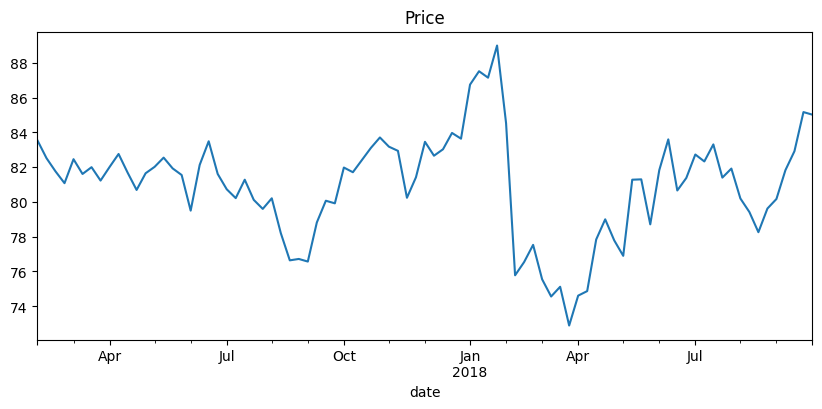

In [2466]:
s = df['PRC']
s_train = df_train['PRC']
s_test = df_test['PRC']

C = df[['npm', 'de_ratio', 'curr_ratio', 'ptb']]
C_train = df_train[['npm', 'de_ratio', 'curr_ratio', 'ptb']]
C_test = df_test[['npm', 'de_ratio', 'curr_ratio', 'ptb']]

# Plot the series
s_train.plot(title='Price', figsize=(10, 4))
plt.show()


In [2467]:
s_train.describe()
s_train.head()

date
2017-02-05    83.54
2017-02-12    82.52
2017-02-19    81.76
2017-02-26    81.08
2017-03-05    82.46
Freq: W-SUN, Name: PRC, dtype: float64

In [2468]:
C_train.head()

,npm,de_ratio,curr_ratio,ptb
date,,,,
2017-02-05,-0.111111,-0.018888,0.010465,0.015357
2017-02-12,-0.111111,-0.018888,0.010465,0.015357
2017-02-19,-0.111111,-0.018888,0.010465,0.015357
2017-02-26,-0.111111,-0.018888,0.010465,0.015357
2017-03-05,-0.111111,-0.018888,0.010465,0.015357


In [2469]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(s_train)
# Print the result of the ADF test
#print("ADF Statistic:", adf_result[0])
#print("p-value:", adf_result[1])
#print("Used Lag:", adf_result[2])
#print("Number of Observations Used:", adf_result[3])
#print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")

Conclusion: The series is non-stationary


In [2470]:
# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(s)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")

Optimal number of differences (d): 1


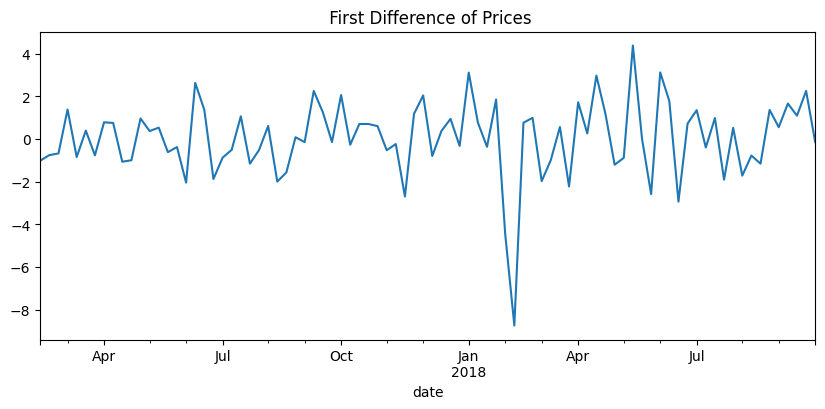

In [2471]:
s_train_diffed = difference(s_train)

s_train_diffed.plot(title=' First Difference of Prices', figsize=(10, 4))
plt.show()

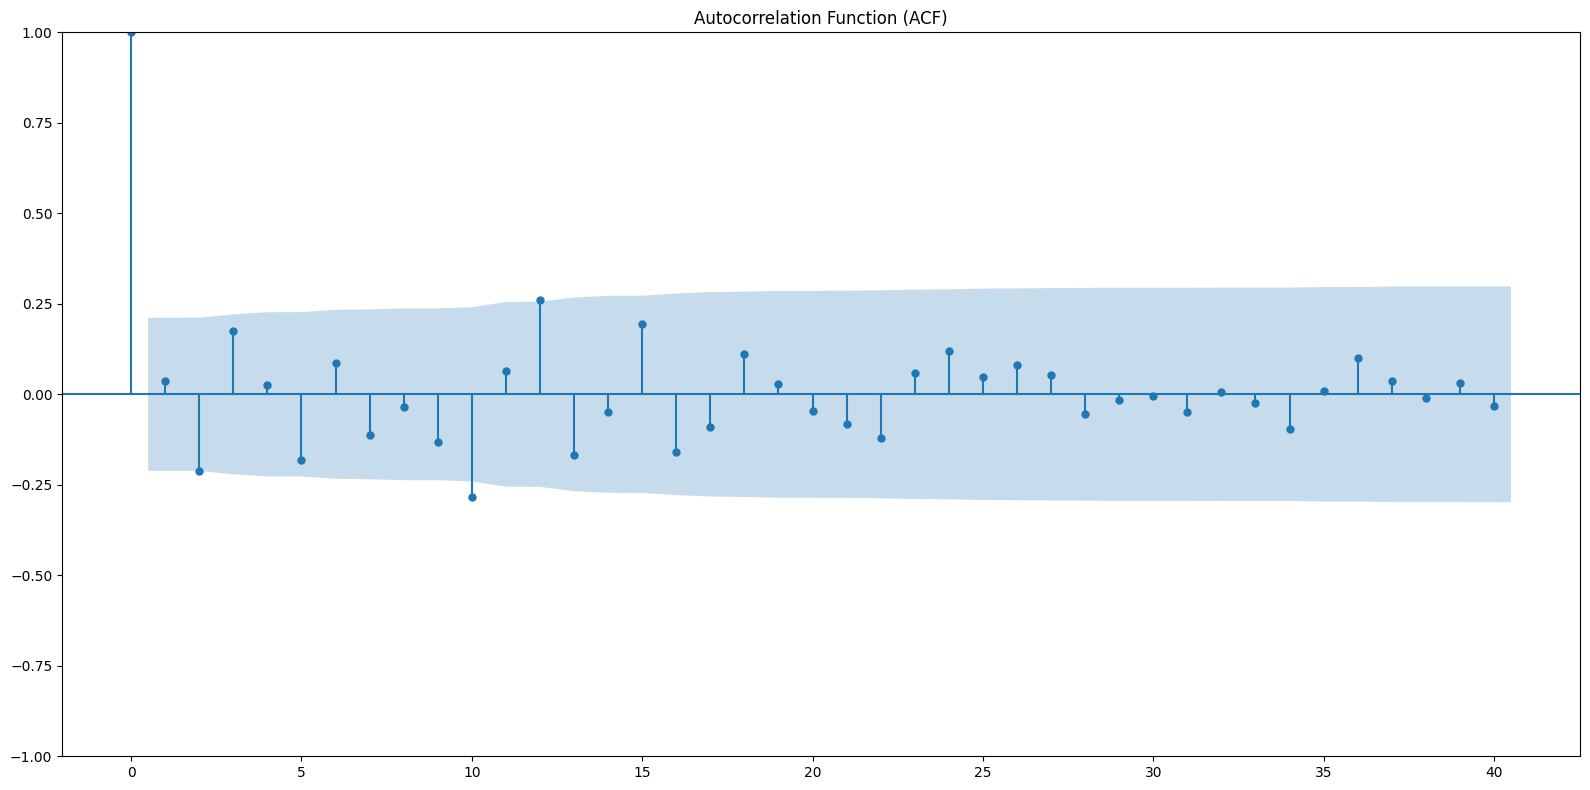

Significant ACF lags:
[2, 10, 12]


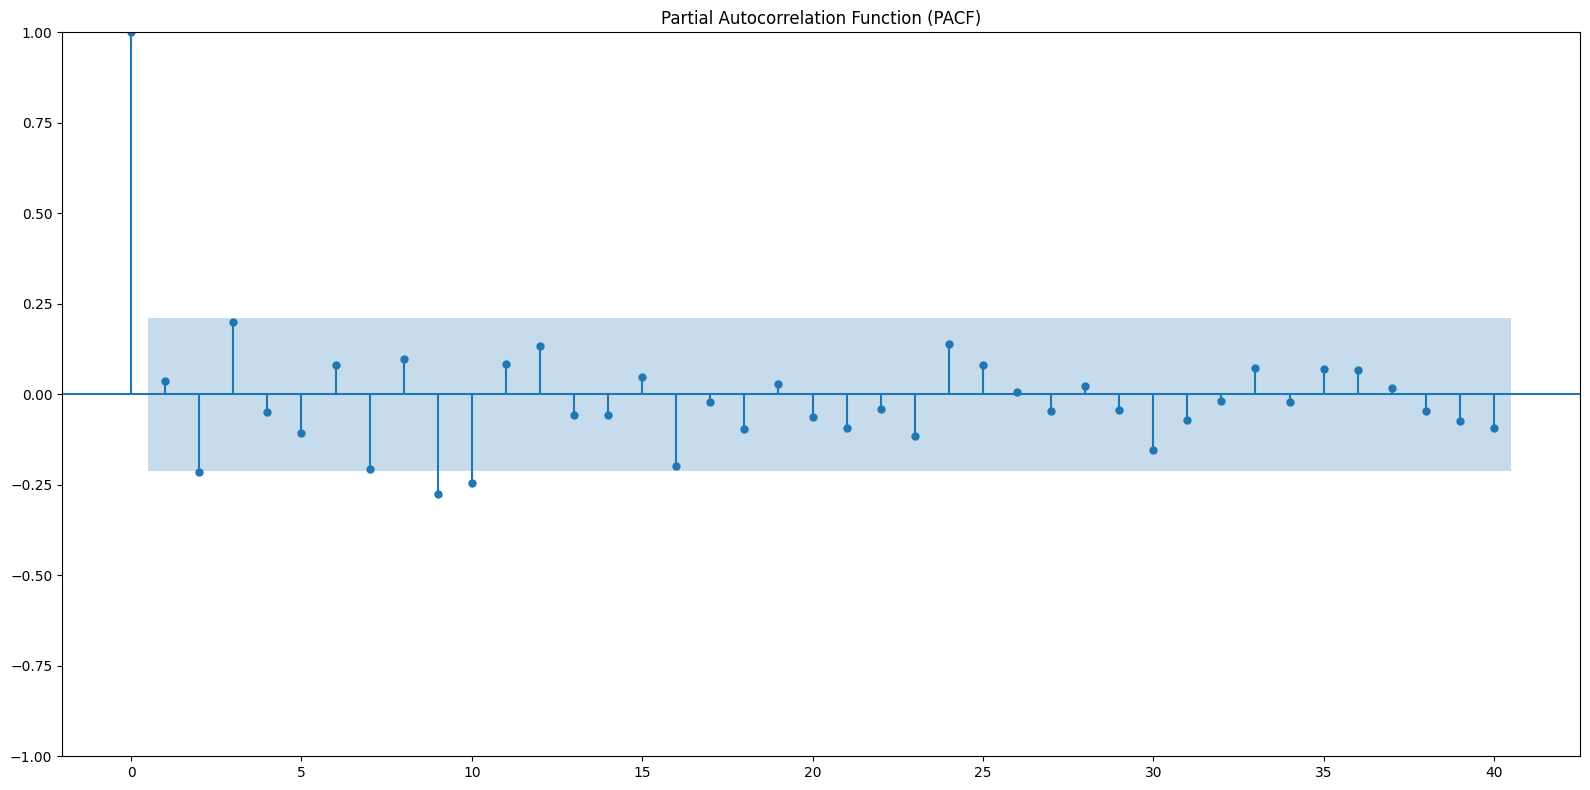

Significant PACF lags:
[2, 7, 9, 10, 16, 24, 30, 39, 40]


In [2472]:
# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
ax.set_title('Autocorrelation Function (ACF) of the First Difference')

# Print the significant lags
q = get_significant_acf_lags(s_train_diffed)
print("Significant ACF lags:")
print(q)

# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_pacf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
ax.set_title('Partial Autocorrelation Function (PACF) of the First Difference')

# Print the significant lags
p = get_significant_pacf_lags(s_train_diffed)

print("Significant PACF lags:")
print(p)

In [2473]:
C_train

,npm,de_ratio,curr_ratio,ptb
date,,,,
2017-02-05,-0.111111,-0.018888,0.010465,0.015357
2017-02-12,-0.111111,-0.018888,0.010465,0.015357
2017-02-19,-0.111111,-0.018888,0.010465,0.015357
2017-02-26,-0.111111,-0.018888,0.010465,0.015357
2017-03-05,-0.111111,-0.018888,0.010465,0.015357
...,...,...,...,...
2018-09-02,-0.036145,-0.012972,-0.006075,-0.018680
2018-09-09,-0.036145,-0.012972,-0.006075,-0.018680
2018-09-16,-0.036145,-0.012972,-0.006075,-0.018680


In [2474]:
# Fit the ARIMA model
model_dict = ContextualisedARIMA(p=p, i=1, q=q, s=s_train, C=C_train, alpha=10)  # ARIMA returns a model_dict

# Access and print the learned parameters
coef = model_dict['coef']  # Coefficients of the AR and MA terms
intercept = model_dict['intercept']  # Intercept of the linear model
X_cols = model_dict['X_cols']  # Column names of the features (lags)

# Display the parameters
print("Learned Parameters:")
print(f"Intercept: {intercept:.4f}")
print("Coefficients:")
for col, weight in zip(X_cols, coef):
    print(f"{col}: {weight:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-04-27 13:16:05.255263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/edocampione/Desktop/Meng Engineering Science/4YP/models/lightning_logs/boot_0_checkpoints exists and is not empty.

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | metamodel | NaiveMetamodel | 1.8 K  | train
-----------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
#p = [2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 24, 30]

p = list(range(1,12))
q = list(range(1,12))

p = list(range(1,31))
q = []

# Fit the ARIMA model
model_dict = ARIMA(p=p, i=1, q=q, s=s_train, alpha=10)  # ARIMA returns a model_dict

# Access and print the learned parameters
coef = model_dict['coef']  # Coefficients of the AR and MA terms
intercept = model_dict['intercept']  # Intercept of the linear model
X_cols = model_dict['X_cols']  # Column names of the features (lags)

# Display the parameters
print("Learned Parameters:")
print(f"Intercept: {intercept:.4f}")
print("Coefficients:")
for col, weight in zip(X_cols, coef):
    print(f"{col}: {weight:.4f}")


Learned Parameters:
Intercept: 0.0399
Coefficients:
lag_1: 0.1392
lag_2: -0.2117
lag_3: 0.1536
lag_4: -0.0010
lag_5: -0.3195
lag_6: 0.1973
lag_7: -0.4257
lag_8: 0.1070
lag_9: -0.4202
lag_10: -0.3019
lag_11: 0.0645
lag_12: -0.0281
lag_13: -0.0298
lag_14: -0.2971
lag_15: 0.1414
lag_16: -0.2559
lag_17: -0.0472
lag_18: -0.0808
lag_19: -0.1516
lag_20: -0.0999
lag_21: -0.2486
lag_22: -0.0233
lag_23: -0.2249
lag_24: 0.1002
lag_25: 0.0646
lag_26: -0.0998
lag_27: -0.0617
lag_28: -0.1152
lag_29: -0.0709
lag_30: -0.2914


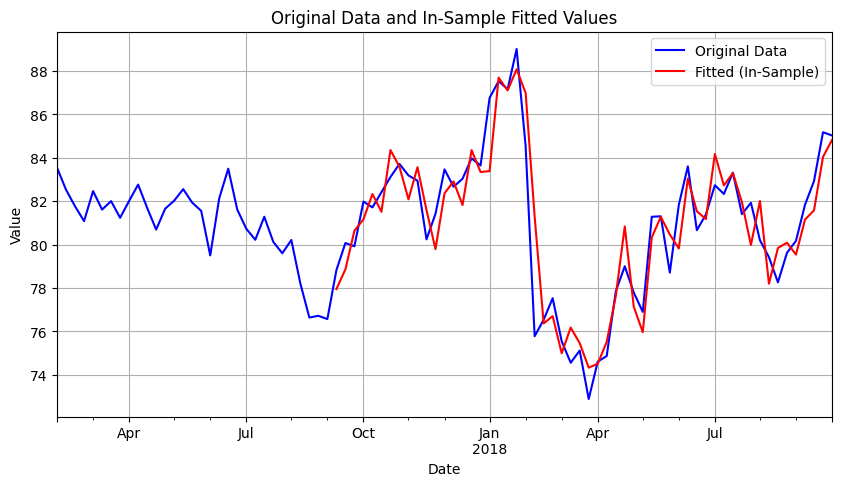

In [ ]:
model = model_dict['model']
X_cols = model_dict['X_cols']
original_series = model_dict['original_series']
differenced_series = model_dict['differenced_series']
i = model_dict['i']  # differencing order
X = model_dict['X_train']
y = model_dict['y_train']

p_lags = model_dict['p']
q_lags = model_dict['q']
residuals = model_dict['residuals']

# Predict on the differenced scale (in-sample predictions)
fitted_diff = model.predict(X)

# Invert differencing (assuming i=1)
if i > 1:
    raise NotImplementedError("Multiple differencing inversion not implemented.")

fitted_diff_series = pd.Series(fitted_diff, index=X.index, name='FittedDiff')

# To invert differencing:
# original_series[t] = original_series[t-1] + differenced_prediction[t]

# Get the initial value before the first fitted point
first_date = fitted_diff_series.index[0]
one_step_before = original_series.index.get_loc(first_date) - 1
initial_value = original_series.iloc[one_step_before]

fitted_original_values = []
current_value = initial_value
for idx in fitted_diff_series.index:
    current_value = current_value + fitted_diff_series.loc[idx]
    fitted_original_values.append(current_value)
    current_value = original_series.loc[idx]

fitted_original_series = pd.Series(fitted_original_values, index=fitted_diff_series.index, name='Fitted')

# Plot the original data and fitted values
plt.figure(figsize=(10,5))
original_series.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='Fitted (In-Sample)', color='red')

plt.title("Original Data and In-Sample Fitted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


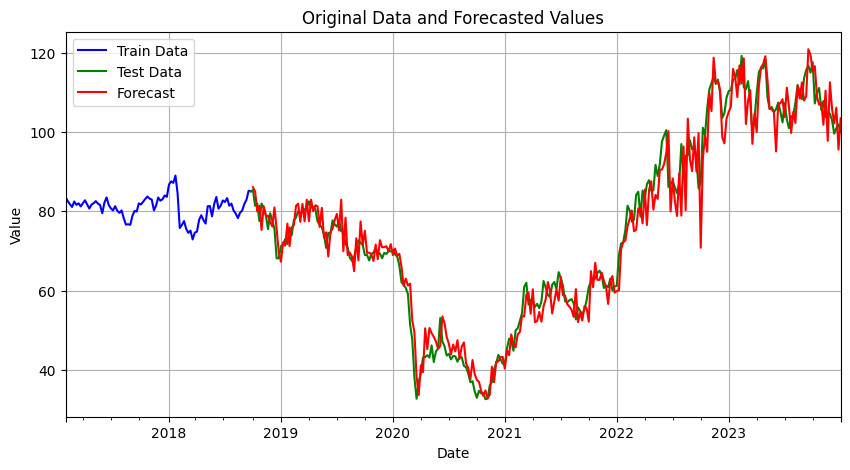

In [ ]:
preds = rolling_forecast(model_dict, s)

# Get the first timestamp
start = s_test.index[1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start, periods=len(preds), freq=f)

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
mypred_series = pred_series
#print(pred_series)

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Train Data', color='blue')
s_test.plot(ax=ax, label='Test Data', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
'''

# Assume that model_dict, df, and forecast() are already defined.
forecast_steps = 150
preds = forecast(model_dict, forecast_steps)

# Get the first timestamp
start = s_test.index[1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start, periods=len(preds), freq=f)

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
mypred_series = pred_series
#print(pred_series)

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Train Data', color='blue')
s_test.plot(ax=ax, label='Test Data', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

'''

'\n\n# Assume that model_dict, df, and forecast() are already defined.\nforecast_steps = 150\npreds = forecast(model_dict, forecast_steps)\n\n# Get the first timestamp\nstart = s_test.index[1]\n\n# Create a datetime index for the forecast period\nfuture_dates = pd.date_range(start, periods=len(preds), freq=f)\n\n# Convert the predictions to a pandas Series\npred_series = pd.Series(preds, index=future_dates, name=\'Forecast\')\nmypred_series = pred_series\n#print(pred_series)\n\n# Plot the original data and the forecasted values\nfig, ax = plt.subplots(figsize=(10, 5))\ns_train.plot(ax=ax, label=\'Train Data\', color=\'blue\')\ns_test.plot(ax=ax, label=\'Test Data\', color=\'green\')\npred_series.plot(ax=ax, label=\'Forecast\', color=\'red\')\n\n\nplt.title("Original Data and Forecasted Values")\nplt.xlabel("Date")\nplt.ylabel("Value")\nplt.legend()\nplt.grid(True)\nplt.show()\n\n'

In [ ]:
s_test

date
2018-09-30     85.02
2018-10-07     85.34
2018-10-14     81.38
2018-10-21     81.97
2018-10-28     77.53
               ...  
2023-12-03    102.99
2023-12-10     99.55
2023-12-17    100.90
2023-12-24    101.91
2023-12-31     99.98
Freq: W-SUN, Name: PRC, Length: 275, dtype: float64

In [ ]:
print(len(preds))

274


In [ ]:
# Create the DataFrame
preds = preds[:len(s_test)]  # truncate preds if too long
s_test = s_test.iloc[:len(preds)]  # truncate s_test if too long (if needed)

comparison = pd.DataFrame({
    'True': s_test.values,
    'Predicted': preds
}, index=s_test.index)

# Add 'Previous' column
comparison.insert(0, 'Previous', comparison['True'].shift(1))

# Fill the first 'Previous' with last value of training set
comparison.iloc[0, comparison.columns.get_loc('Previous')] = s_train.iloc[-1]

# Add 'True Difference' and 'Predicted Difference' columns
comparison['True Difference'] = comparison['True'] - comparison['Previous']
comparison['Predicted Difference'] = comparison['Predicted'] - comparison['Previous']

# Show it
comparison.tail(40)


,Previous,True,Predicted,True Difference,Predicted Difference
date,,,,,
2023-03-26,99.84,103.53,99.983536,3.69,0.143536
2023-04-02,103.53,109.66,111.476186,6.13,7.946186
2023-04-09,109.66,115.05,116.260220,5.39,6.600220
2023-04-16,115.05,116.05,117.105563,1.00,2.055563
2023-04-23,116.05,116.01,119.072716,-0.04,3.022716
2023-04-30,116.01,118.34,113.206005,2.33,-2.803995
2023-05-07,118.34,108.68,105.832128,-9.66,-12.507872
2023-05-14,108.68,105.78,105.669283,-2.90,-3.010717
2023-05-21,105.78,106.26,104.999145,0.48,-0.780855


In [ ]:
directional_accuracy = 100 * (np.sign(comparison['True Difference']) == np.sign(comparison['Predicted Difference'])).mean()
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

# MSE and MAE
mse = mean_squared_error(comparison['True'], comparison['Predicted'])
mae = mean_absolute_error(comparison['True'], comparison['Predicted'])

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Directional Accuracy: 70.07%
Mean Squared Error (MSE): 11.9357
Mean Absolute Error (MAE): 2.5857


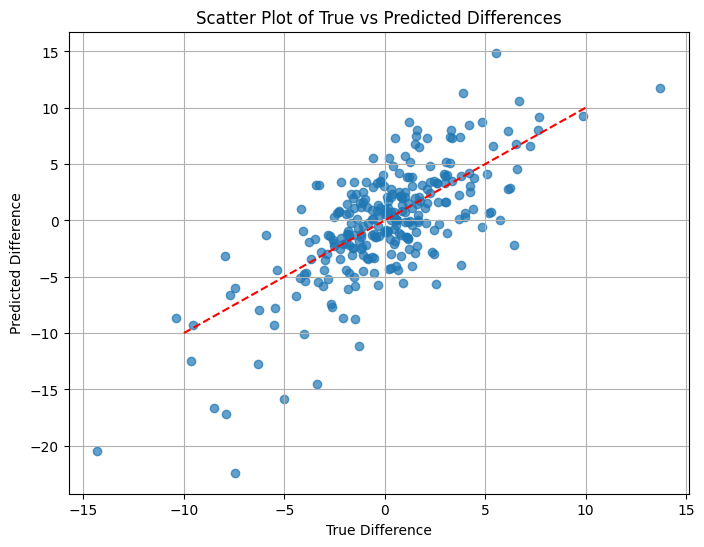

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(comparison['True Difference'], comparison['Predicted Difference'], alpha=0.7)
plt.plot([-10, 10], [-10, 10], 'r--')  # 45-degree line for reference (perfect prediction)
plt.title('Scatter Plot of True vs Predicted Differences')
plt.xlabel('True Difference')
plt.ylabel('Predicted Difference')
plt.grid(True)
plt.show()